# `kissim`-based kinome tree

We generate `kissim`-based kinome matrices and trees based on three different parameters:

- Feature weighting schemes
- DFG conformations
  - Kinase matrix based on all structures/fingerprints (**DFG-in and DFG-out**)
  - Kinase matrix based on structure/fingerprints in **DFG-in** conformation only
  - Kinase matrix based on structure/fingerprints in **DFG-out** conformation only
- Clustering methods

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio import Phylo
from opencadd.databases.klifs import setup_remote
from IPython.display import display, Markdown
from kissim.comparison import FingerprintDistanceGenerator
from kissim.comparison import matrix, tree

from src.paths import PATH_RESULTS

In [3]:
matplotlib.rc("font", size=6)

In [4]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = PATH_RESULTS

In [5]:
# Set bit coverage between fingerprint pairs
COVERAGE_MIN = 0.8
WEIGHTING_SCHEMES = ["15", "110", "101", "100"]
CONFORMATIONS = ["all", "dfg_in", "dfg_out"]
CLUSTERING_METHODS = ["ward", "average", "weighted"]
FIG_HEIGHT = {"all": 25, "dfg_in": 25, "dfg_out": 10}

## Data

- 20210630 KLIFS download
- DFG-all/in/out

## Kinase-color mapping

In [6]:
klifs_session = setup_remote()
kinases = klifs_session.kinases.all_kinases(species="Human")
kinases = klifs_session.kinases.by_kinase_klifs_id(
    kinases["kinase.klifs_id"].to_list()
)
kinases = kinases[["kinase.klifs_name", "kinase.group"]]
kinase_groups = kinases["kinase.group"].sort_values().unique()
colors = [
    "red",
    "orange",
    "yellowgreen",
    "limegreen",
    "turquoise",
    "cornflowerblue",
    "grey",
    "mediumblue",
    "darkorchid",
    "violet",
]
groups_to_color = {g: c for g, c in zip(kinase_groups, colors)}
kinases["color"] = kinases["kinase.group"].apply(lambda x: groups_to_color[x])
label_colors = kinases.set_index("kinase.klifs_name")["color"].to_dict()
LABEL_COLORS = label_colors

## Helper functions

In [7]:
def generate_trees(
    path_results=RESULTS,
    weighting_schemes=WEIGHTING_SCHEMES,
    conformations=CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    coverage_min=COVERAGE_MIN,
):
    def _load_fingerprint_distances(path_results, weighting):
        """
        Load fingerprint distances (all conformations).
        """

        if weighting == "15":
            filepath = path_results / "fingerprint_distances.csv.bz2"
        else:
            filepath = path_results / f"fingerprint_distances_{weighting}.csv.bz2"
        fingerprint_distances = FingerprintDistanceGenerator.from_csv(filepath)

        return fingerprint_distances.data

    def _generate_distance_matrix(
        distances, coverage_min, conformation, weighting, path
    ):
        """
        Generate and save distance matrix.
        """
        distance_matrix = matrix.kinase_distance_matrix(
            distances,
            by="minimum",
            fill_diagonal=True,
            coverage_min=coverage_min,
        )
        distance_matrix.to_csv(
            path / f"kinase_matrix_{coverage_min}_{conformation}_{weighting}.csv"
        )
        return distance_matrix

    def _generate_tree(distance_matrix, weighting, cmethod, coverage_min, path):
        """
        Generate and save tree.
        """
        tree.from_distance_matrix(
            distance_matrix,
            path / f"tree_{coverage_min}_{weighting}_{cmethod}.tree",
            clustering_method=cmethod,
        )

    for conformation in conformations:
        path = RESULTS / conformation
        print(path)
        (path / "matrices").mkdir(parents=True, exist_ok=True)
        (path / "trees").mkdir(parents=True, exist_ok=True)

        for weighting in weighting_schemes:
            distances = _load_fingerprint_distances(path, weighting)
            distance_matrix = _generate_distance_matrix(
                distances, coverage_min, conformation, weighting, path / "matrices"
            )
            for cmethod in clustering_methods:
                print(f"{weighting}_{conformation}_{cmethod}_{coverage_min}")
                _generate_tree(
                    distance_matrix, weighting, cmethod, coverage_min, path / "trees"
                )

In [8]:
def visualize_trees(
    path_results=RESULTS,
    weighting_schemes=WEIGHTING_SCHEMES,
    conformations=CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    fig_height=FIG_HEIGHT,
    label_colors=LABEL_COLORS,
    coverage_min=COVERAGE_MIN,
):
    for weighting in weighting_schemes:
        display(Markdown(f"### Weighing {weighting}"))
        for conformation in conformations:
            display(Markdown(f"#### DFG-{conformation}"))
            for cmethod in clustering_methods:
                display(Markdown(f"##### {cmethod}"))
                path_newick = (
                    path_results
                    / f"{conformation}/trees/"
                    / f"tree_{coverage_min}_{weighting}_{cmethod}.tree"
                )
                kissim_tree = Phylo.read(path_newick, "newick")
                kissim_tree.ladderize()  # Flip branches so deeper clades are displayed at top

                fig, ax = plt.subplots(1, 1, figsize=(5, fig_height[conformation]))
                ax.set_title(
                    f"weighting {weighting} | {conformation} "
                    f"| cmethod {cmethod} | {kissim_tree.count_terminals()} leafs"
                )
                Phylo.draw(kissim_tree, axes=ax, label_colors=label_colors)

## Generate matrix and tree files

In [9]:
%%time
generate_trees()

/home/dominique/Documents/GitHub/kissim_app/src/../results/all
15_all_ward_0.8
15_all_average_0.8
15_all_weighted_0.8
110_all_ward_0.8
110_all_average_0.8
110_all_weighted_0.8
101_all_ward_0.8
101_all_average_0.8
101_all_weighted_0.8
100_all_ward_0.8
100_all_average_0.8
100_all_weighted_0.8
/home/dominique/Documents/GitHub/kissim_app/src/../results/dfg_in
15_dfg_in_ward_0.8
15_dfg_in_average_0.8
15_dfg_in_weighted_0.8
110_dfg_in_ward_0.8
110_dfg_in_average_0.8
110_dfg_in_weighted_0.8
101_dfg_in_ward_0.8
101_dfg_in_average_0.8
101_dfg_in_weighted_0.8
100_dfg_in_ward_0.8
100_dfg_in_average_0.8
100_dfg_in_weighted_0.8
/home/dominique/Documents/GitHub/kissim_app/src/../results/dfg_out
15_dfg_out_ward_0.8
15_dfg_out_average_0.8
15_dfg_out_weighted_0.8
110_dfg_out_ward_0.8
110_dfg_out_average_0.8
110_dfg_out_weighted_0.8
101_dfg_out_ward_0.8
101_dfg_out_average_0.8
101_dfg_out_weighted_0.8
100_dfg_out_ward_0.8
100_dfg_out_average_0.8
100_dfg_out_weighted_0.8
CPU times: user 4min 47s, sys: 14

## Visualize trees

### Weighing 15

#### DFG-all

##### ward

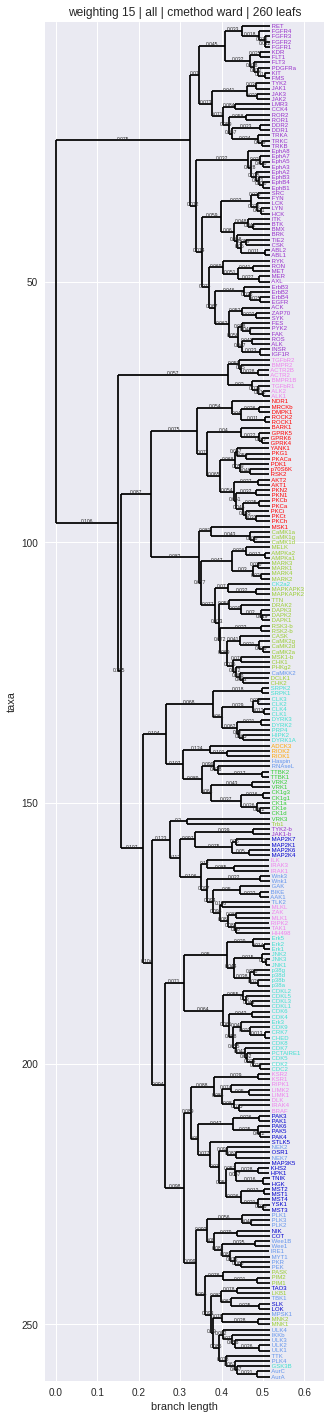

##### average

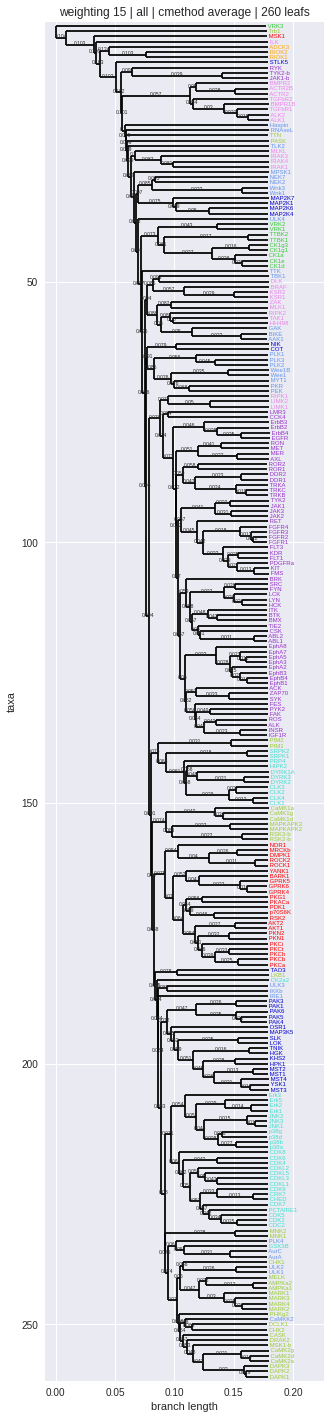

##### weighted

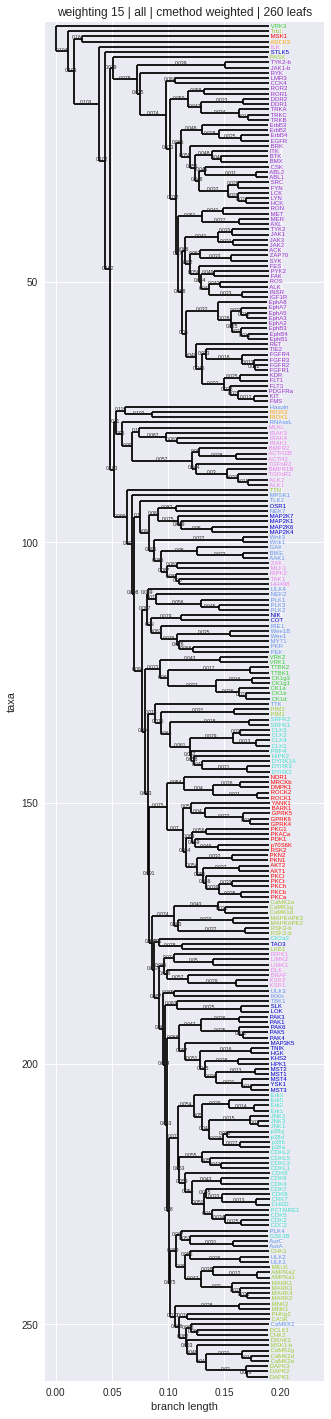

#### DFG-dfg_in

##### ward

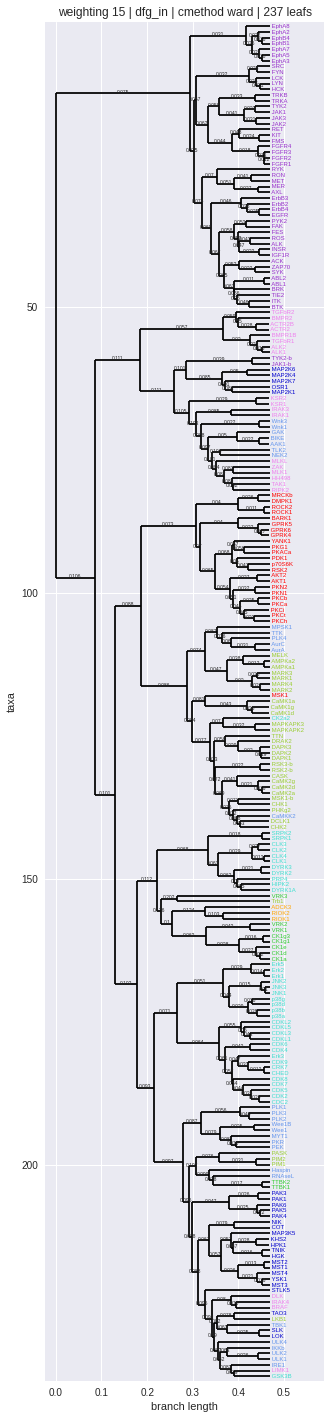

##### average

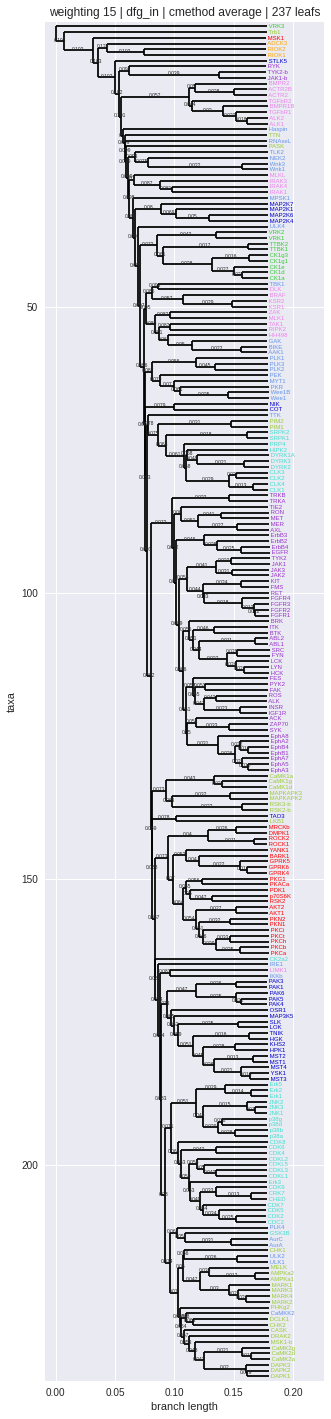

##### weighted

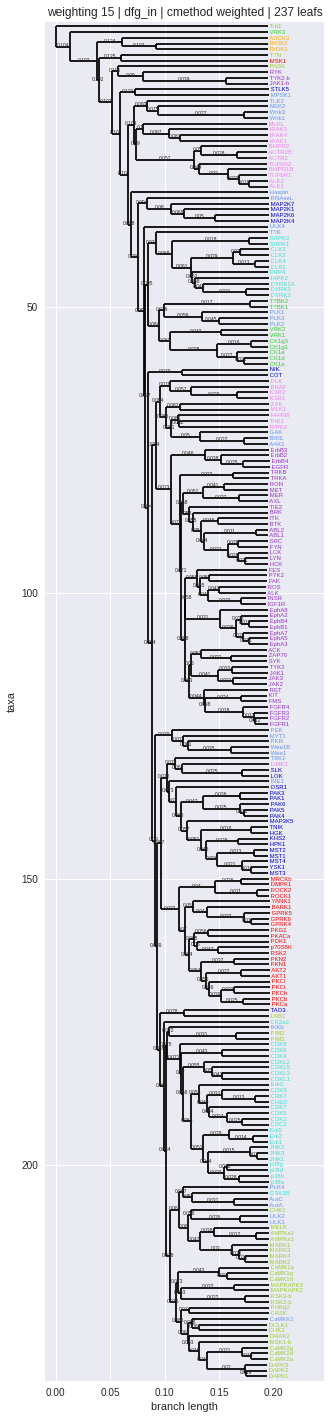

#### DFG-dfg_out

##### ward

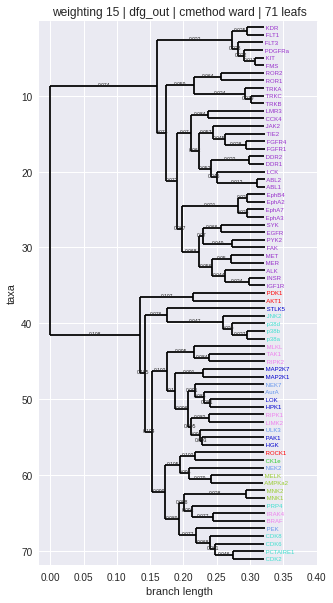

##### average

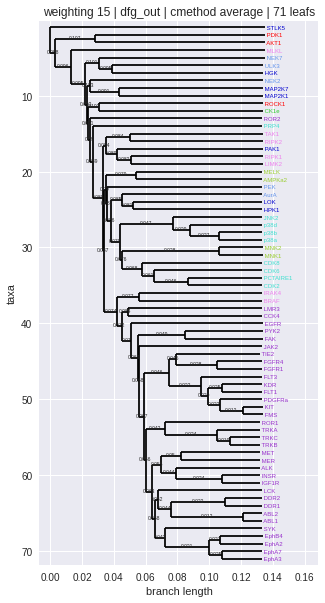

##### weighted

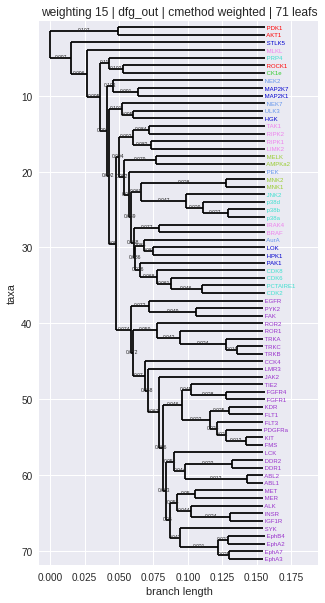

### Weighing 110

#### DFG-all

##### ward

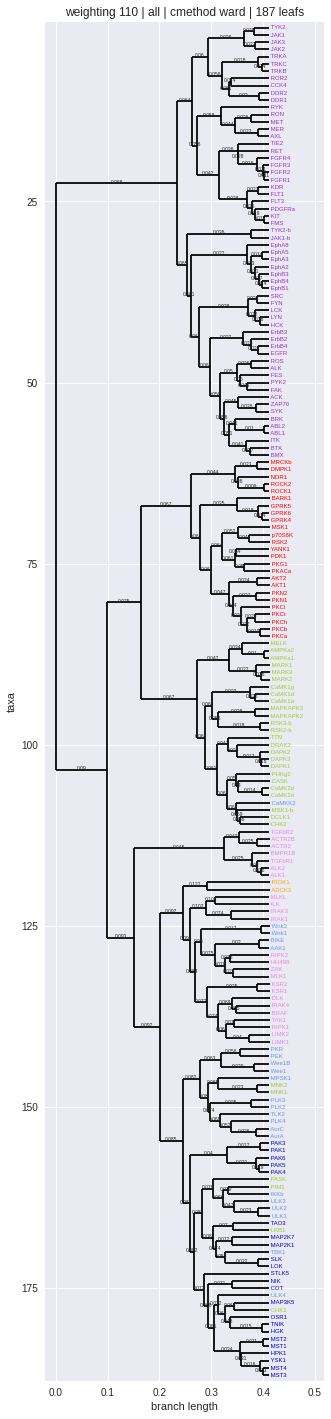

##### average

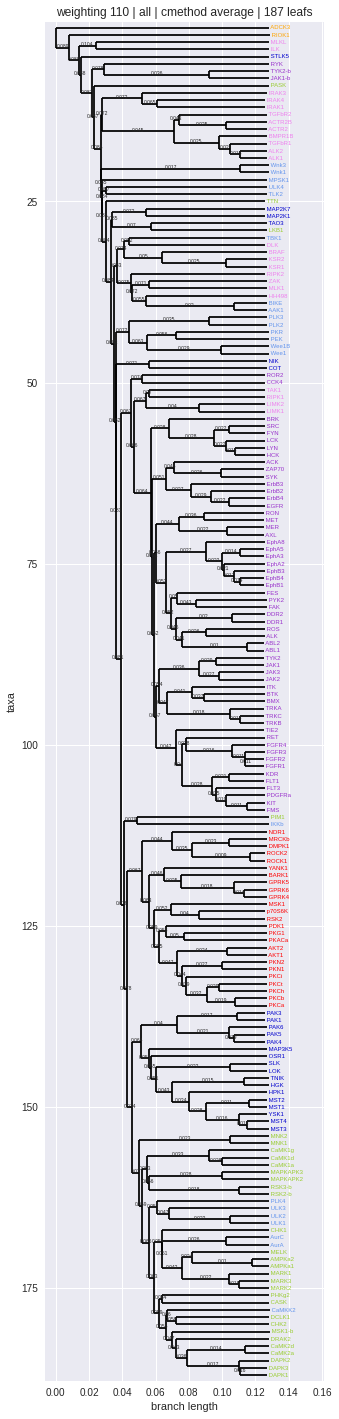

##### weighted

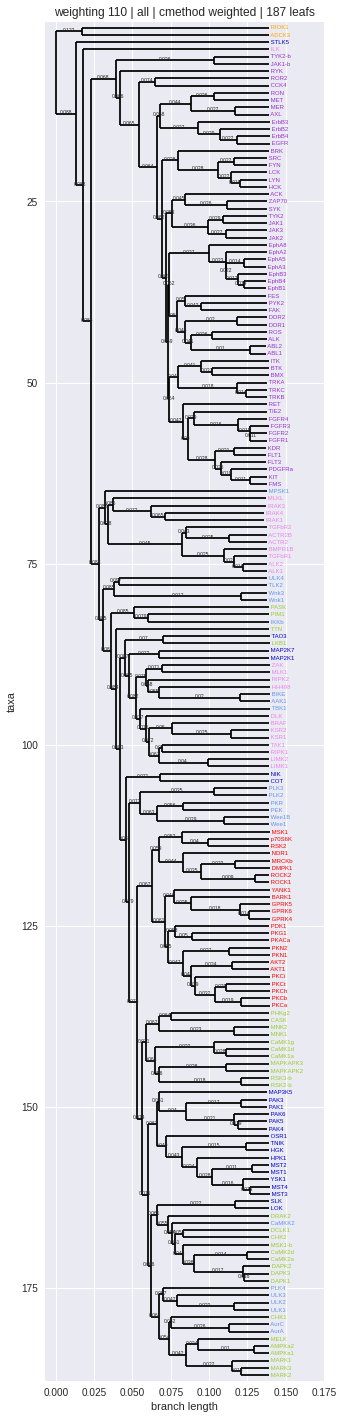

#### DFG-dfg_in

##### ward

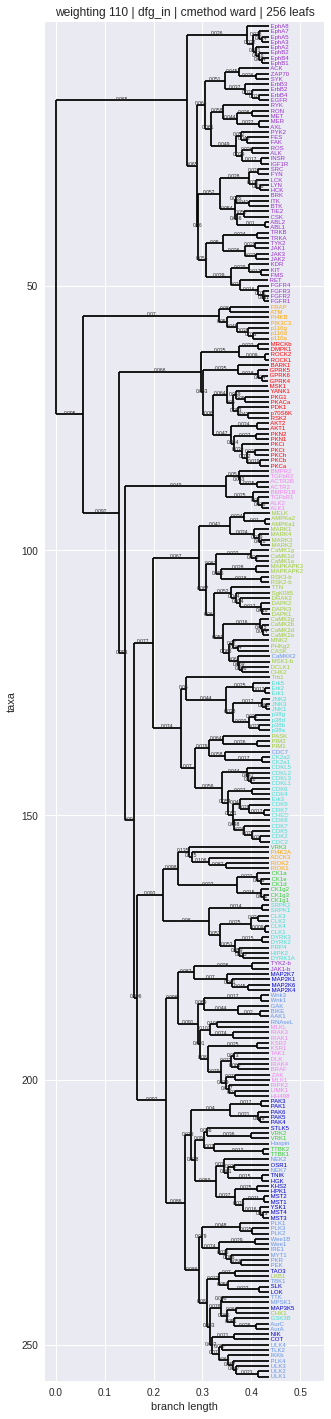

##### average

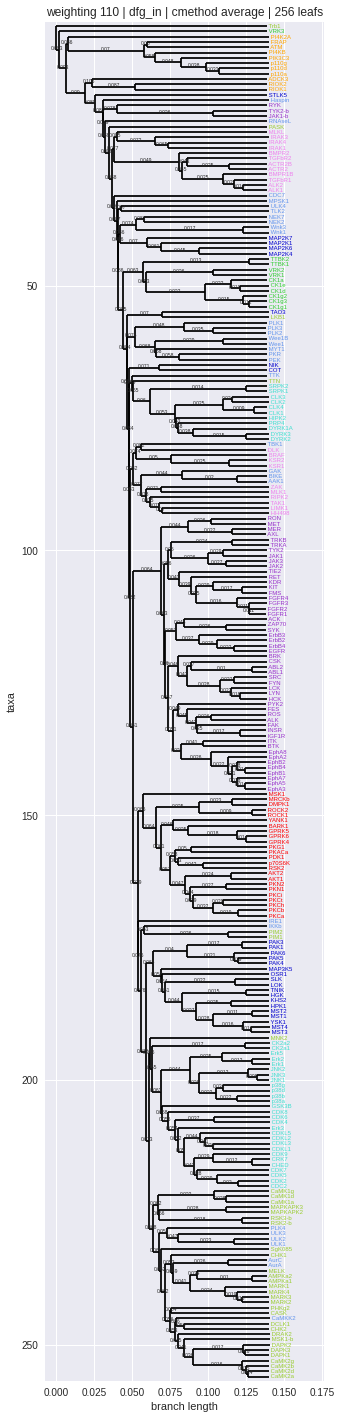

##### weighted

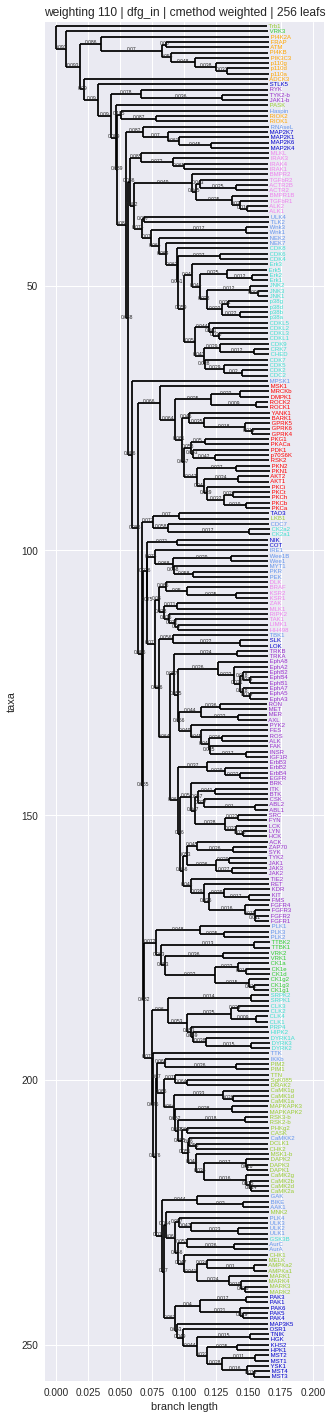

#### DFG-dfg_out

##### ward

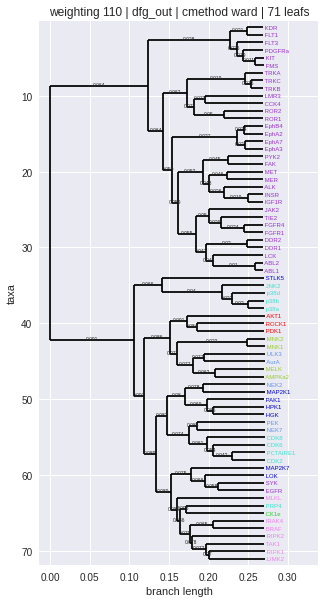

##### average

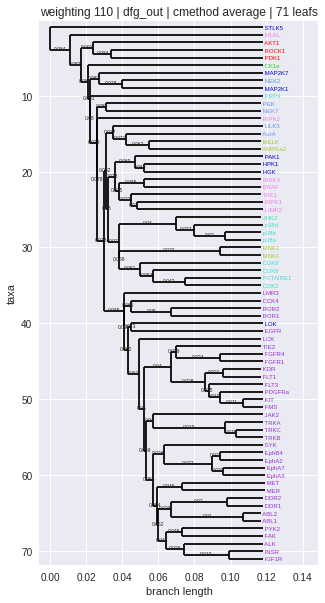

##### weighted

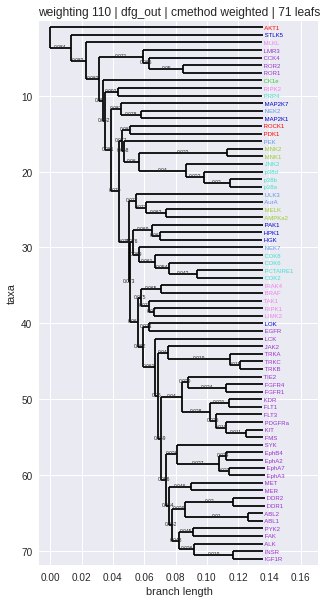

### Weighing 101

#### DFG-all

##### ward

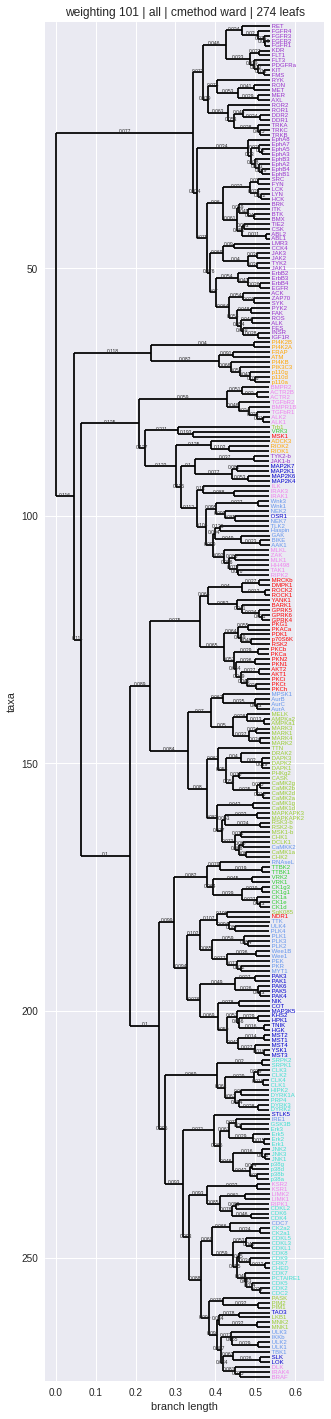

##### average

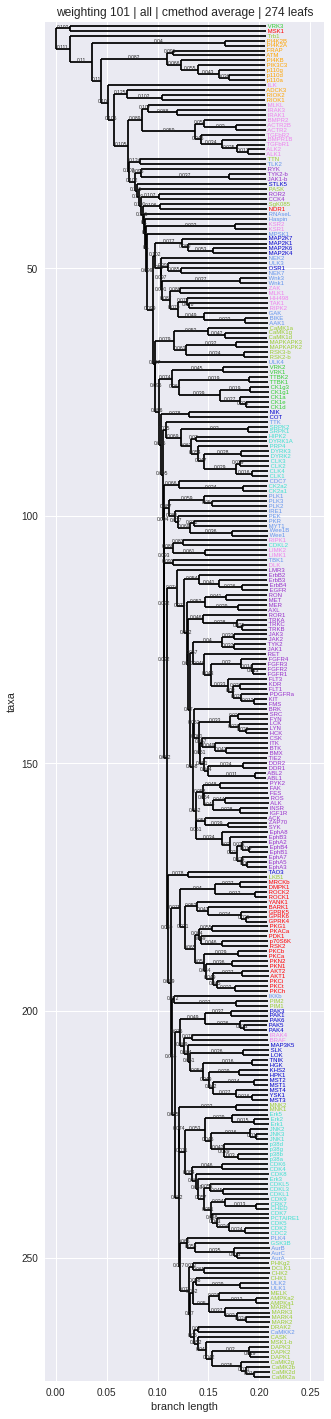

##### weighted

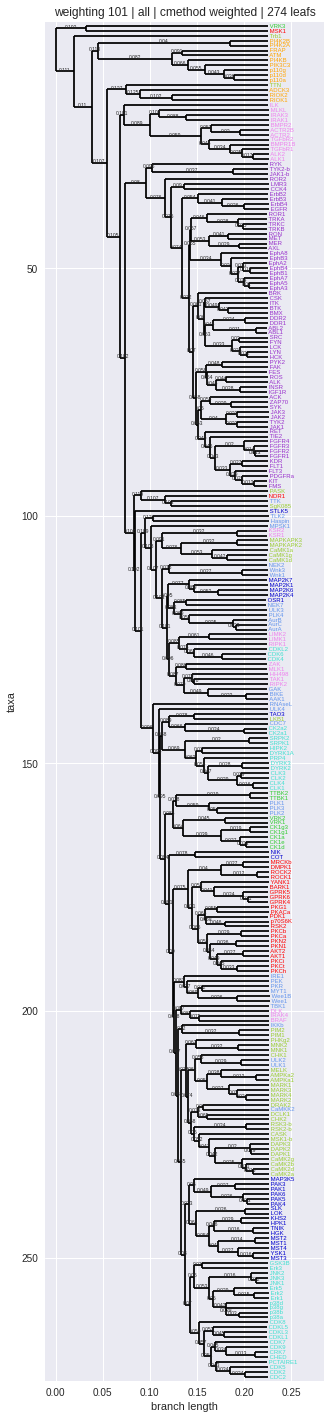

#### DFG-dfg_in

##### ward

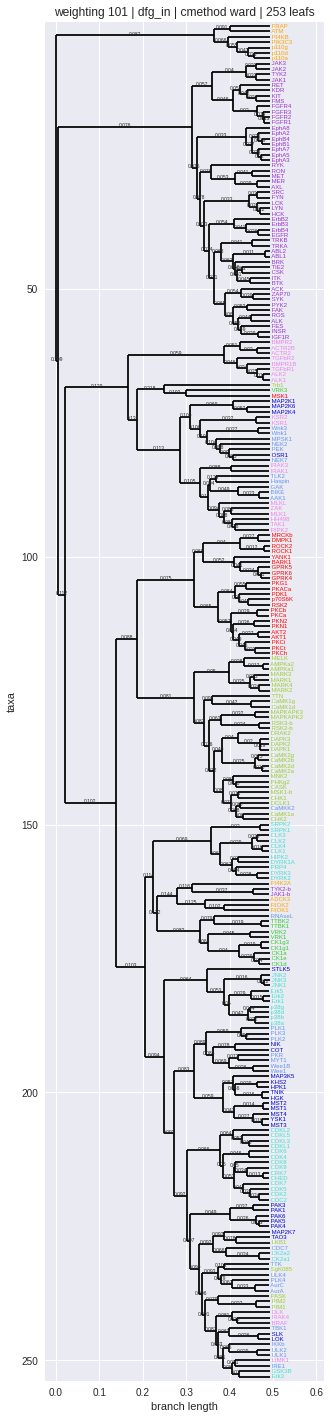

##### average

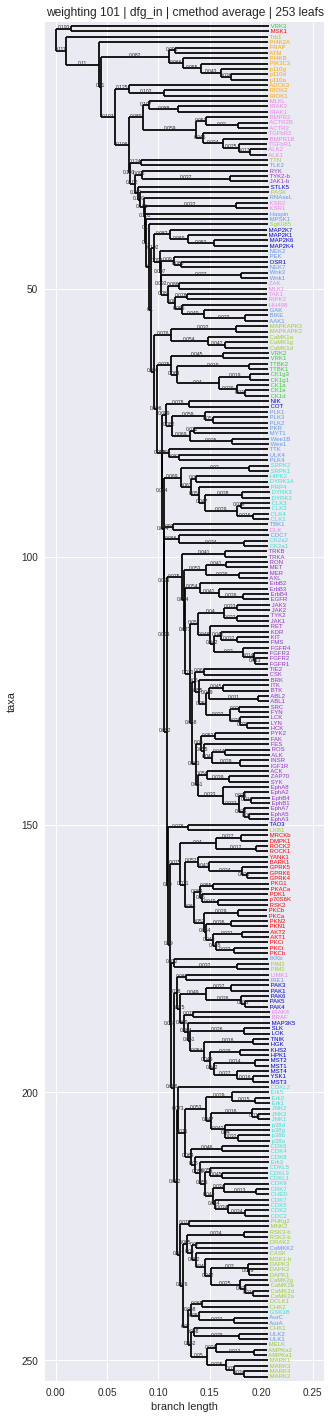

##### weighted

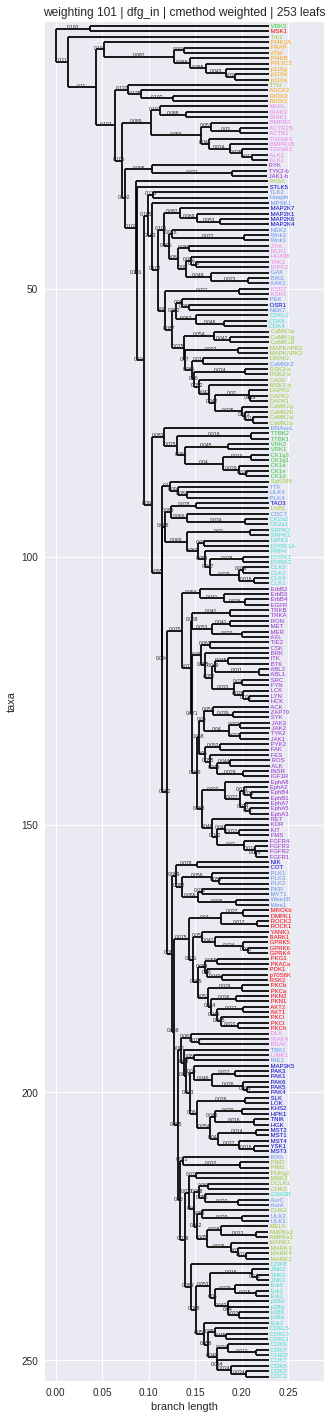

#### DFG-dfg_out

##### ward

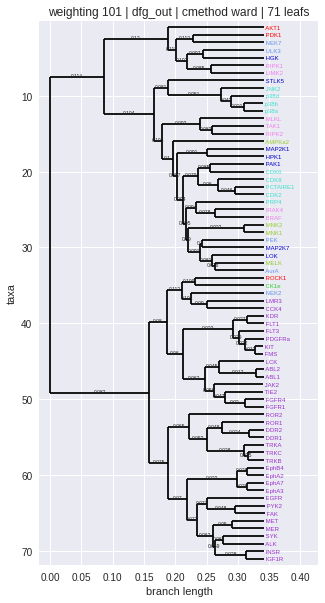

##### average

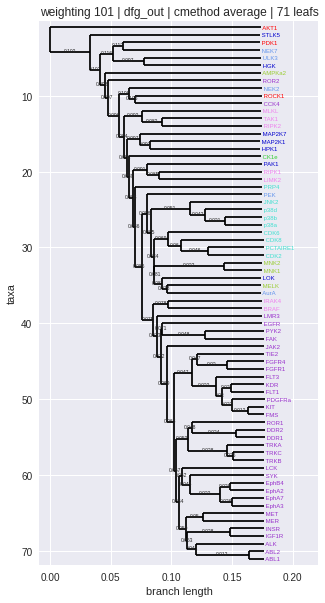

##### weighted

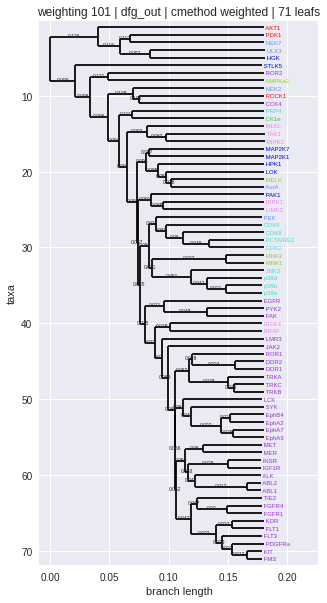

### Weighing 100

#### DFG-all

##### ward

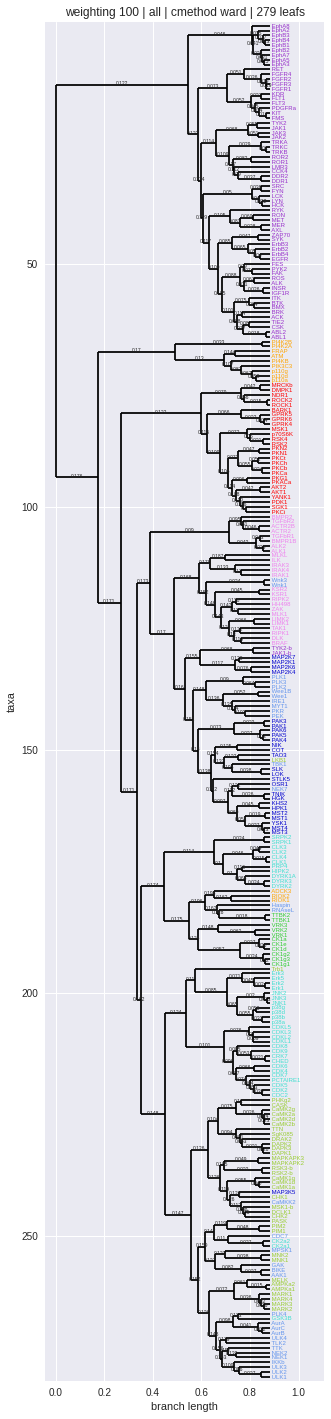

##### average

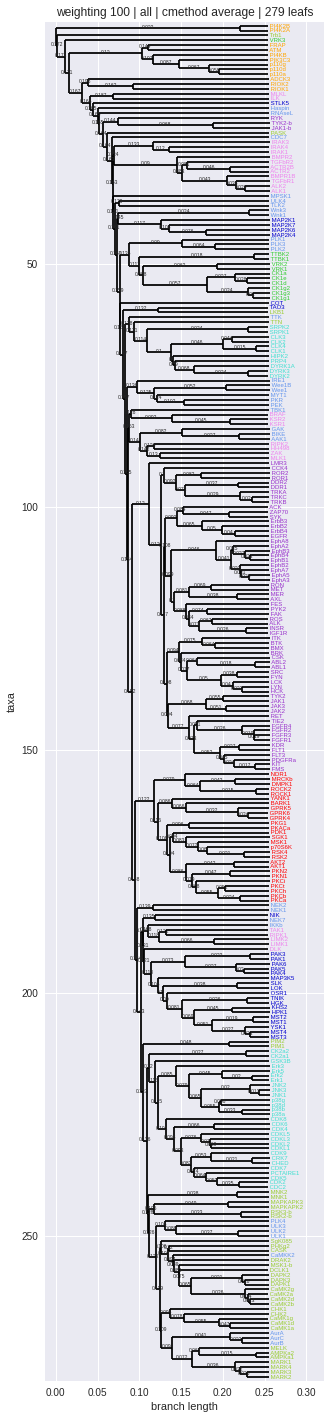

##### weighted

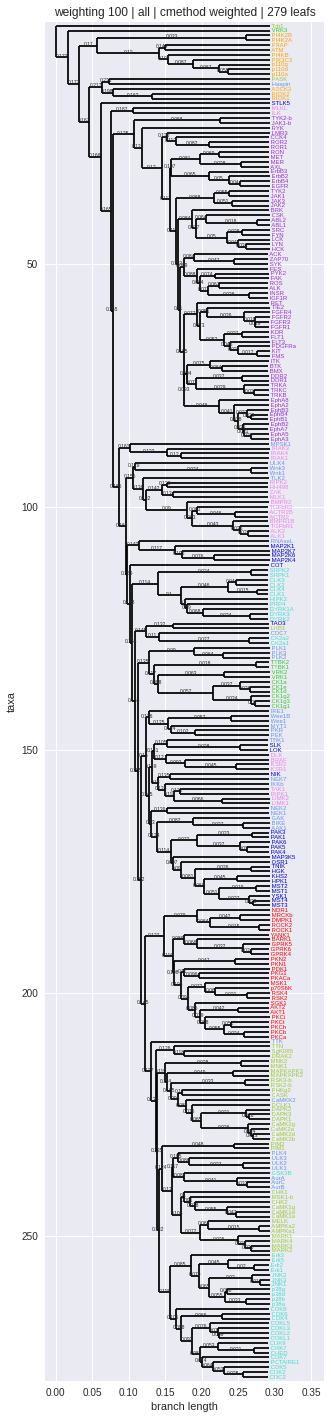

#### DFG-dfg_in

##### ward

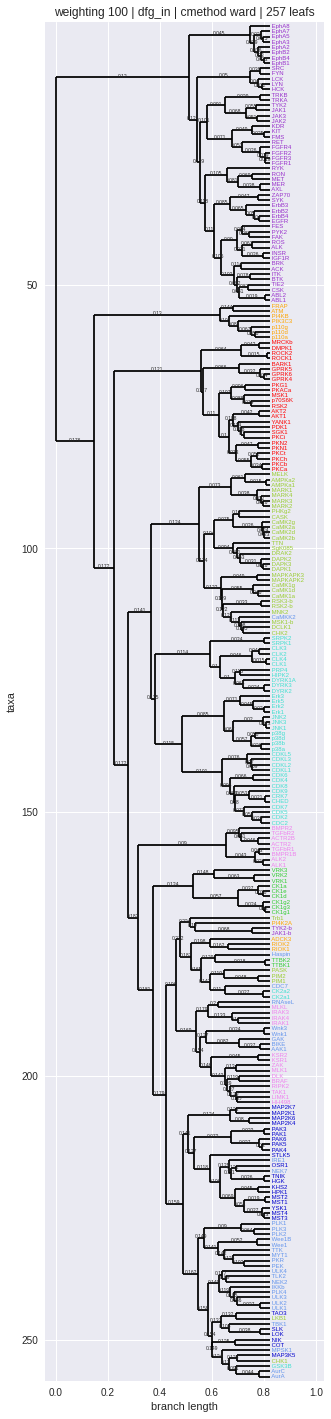

##### average

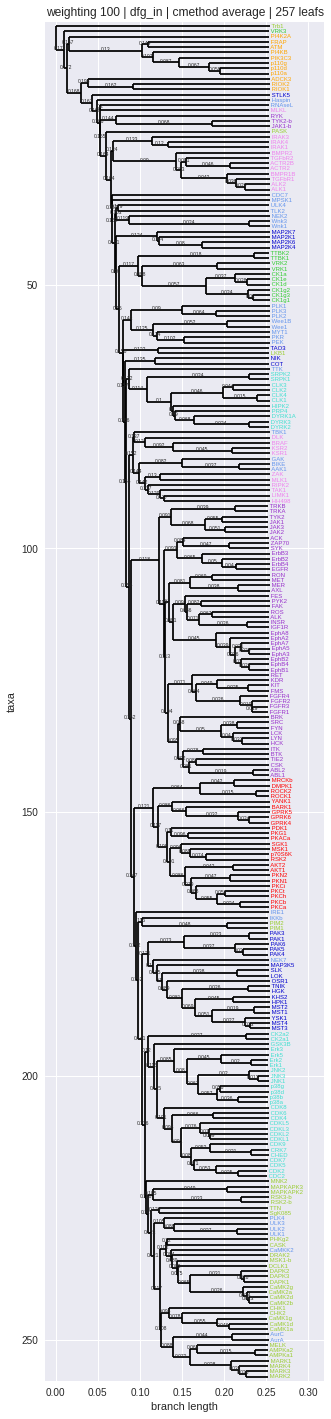

##### weighted

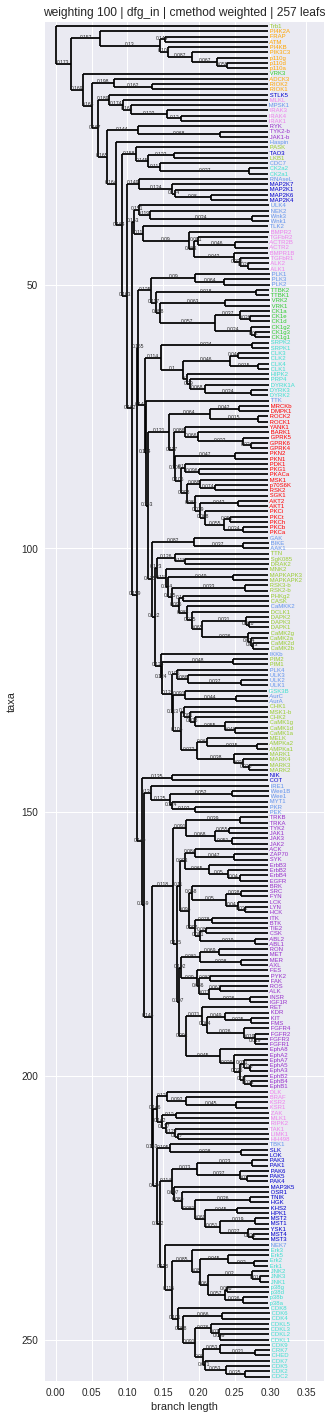

#### DFG-dfg_out

##### ward

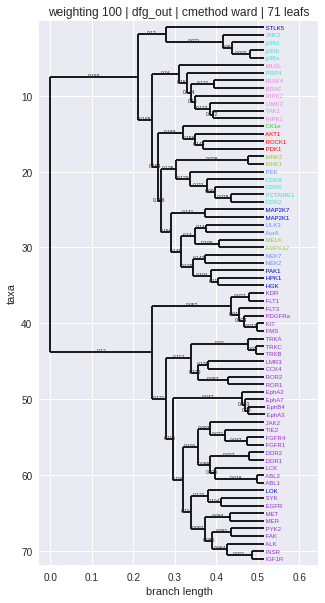

##### average

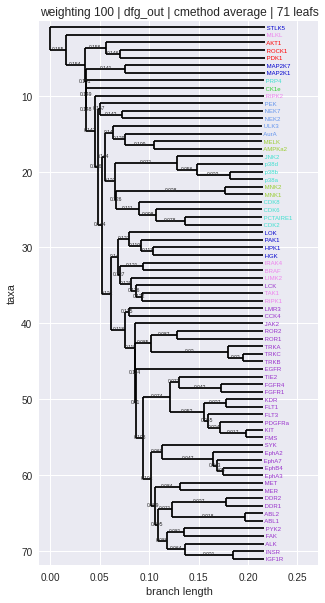

##### weighted

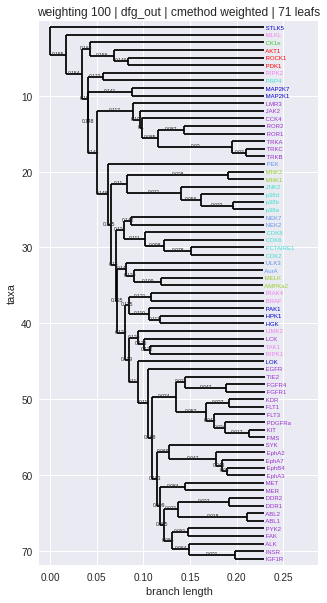

CPU times: user 41.5 s, sys: 3.89 s, total: 45.4 s
Wall time: 40.3 s


In [10]:
%%time
visualize_trees()

## Appendix: EGFR's top X kinases

In [22]:
def _top_kinases(kinase_matrix, target):

    kinases_to_target = kinase_matrix[target].sort_values()
    kinases_to_target.name = "distance"
    kinases_to_target.index.name = "kinase.klifs_name"
    kinases_to_target = kinases_to_target.reset_index()

    klifs_session = setup_remote()
    kinase_groups = klifs_session.kinases.by_kinase_name(
        kinases_to_target["kinase.klifs_name"].tolist(), species="Human"
    )[["kinase.klifs_name", "kinase.group"]]

    kinases_to_target = kinases_to_target.merge(kinase_groups)

    return kinases_to_target


def top_kinases(
    conformation, 
    path_results=RESULTS, 
    coverage_min=COVERAGE_MIN, 
    weighting_schemes=WEIGHTING_SCHEMES
):

    for weighting in weighting_schemes:
        display(Markdown(f"#### Weighting {weighting}"))
        filename = f"{conformation}/matrices/kinase_matrix_{coverage_min}_{conformation}_{weighting}.csv"
        path = path_results / filename
        kinase_matrix = pd.read_csv(path, index_col=0)
        for kinase, top_n in zip(kinase_list, top_n_list):
            display(Markdown(kinase))
            display(_top_kinases(kinase_matrix, kinase)[:top_n])

In [15]:
kinase_list = ["EGFR", "SLK", "LOK"]
top_n_list = [40, 10, 10]

In [23]:
top_kinases("dfg_in")

#### Weighting 15

EGFR

,kinase.klifs_name,distance,kinase.group
0,EGFR,0.000000,TK
1,ErbB4,0.024878,TK
2,ErbB2,0.039648,TK
3,ErbB3,0.046541,TK
4,SYK,0.053504,TK
5,FGFR4,0.061678,TK
6,BTK,0.062406,TK
7,ABL1,0.063537,TK
8,RET,0.064704,TK
9,IGF1R,0.065141,TK


SLK

,kinase.klifs_name,distance,kinase.group
0,SLK,0.000000,STE
1,LOK,0.024782,STE
2,SYK,0.068371,TK
3,CDK7,0.071377,CMGC
4,CDK2,0.072183,CMGC
5,MST1,0.073085,STE
6,CDK9,0.073337,CMGC
7,MST2,0.074674,STE
8,ErbB4,0.074705,TK
9,MST3,0.074934,STE


LOK

,kinase.klifs_name,distance,kinase.group
0,LOK,0.000000,STE
1,SLK,0.024782,STE
2,SYK,0.066887,TK
3,MST3,0.069340,STE
4,MST1,0.069404,STE
5,EGFR,0.071240,TK
6,ErbB4,0.071440,TK
7,HPK1,0.071493,STE
8,MST2,0.072390,STE
9,CDK9,0.072943,CMGC


#### Weighting 110

EGFR

,kinase.klifs_name,distance,kinase.group
0,EGFR,0.000000,TK
1,ErbB4,0.022201,TK
2,ErbB2,0.028733,TK
3,ErbB3,0.040428,TK
4,SYK,0.048059,TK
5,FGFR4,0.054677,TK
6,BTK,0.055279,TK
7,ALK,0.056131,TK
8,ZAP70,0.056132,TK
9,ABL1,0.056186,TK


SLK

,kinase.klifs_name,distance,kinase.group
0,SLK,0.000000,STE
1,LOK,0.021666,STE
2,SYK,0.061741,TK
3,CDK7,0.063619,CMGC
4,MST1,0.064199,STE
5,CaMKK2,0.065185,Other
6,ZAP70,0.065527,TK
7,MST3,0.065608,STE
8,CDK2,0.065815,CMGC
9,MST2,0.066182,STE


LOK

,kinase.klifs_name,distance,kinase.group
0,LOK,0.000000,STE
1,SLK,0.021666,STE
2,MST3,0.059894,STE
3,SYK,0.061003,TK
4,MST1,0.061154,STE
5,MST2,0.064324,STE
6,YSK1,0.064397,STE
7,ErbB4,0.064520,TK
8,EGFR,0.064585,TK
9,ZAP70,0.064927,TK


#### Weighting 101

EGFR

,kinase.klifs_name,distance,kinase.group
0,EGFR,0.000000,TK
1,ErbB4,0.025579,TK
2,ErbB2,0.047061,TK
3,ErbB3,0.048845,TK
4,SYK,0.051863,TK
5,BTK,0.061146,TK
6,FGFR4,0.062038,TK
7,RET,0.062413,TK
8,ABL1,0.062553,TK
9,ITK,0.063901,TK


SLK

,kinase.klifs_name,distance,kinase.group
0,SLK,0.000000,STE
1,LOK,0.025833,STE
2,SYK,0.066498,TK
3,CDK2,0.070309,CMGC
4,CDK9,0.071498,CMGC
5,CDK7,0.072423,CMGC
6,MST1,0.072695,STE
7,ErbB4,0.073574,TK
8,TNIK,0.074575,STE
9,EGFR,0.075054,TK


LOK

,kinase.klifs_name,distance,kinase.group
0,LOK,0.000000,STE
1,SLK,0.025833,STE
2,SYK,0.065373,TK
3,HPK1,0.068300,STE
4,EGFR,0.069583,TK
5,CDK9,0.070783,CMGC
6,MST1,0.071270,STE
7,ErbB4,0.071458,TK
8,MST3,0.071481,STE
9,MST2,0.072580,STE


#### Weighting 100

EGFR

,kinase.klifs_name,distance,kinase.group
0,EGFR,0.000000,TK
1,ErbB4,0.039718,TK
2,ErbB2,0.048144,TK
3,ErbB3,0.072011,TK
4,SYK,0.088728,TK
5,FGFR4,0.098413,TK
6,ABL1,0.104537,TK
7,ZAP70,0.104792,TK
8,INSR,0.104807,TK
9,BTK,0.104830,TK


SLK

,kinase.klifs_name,distance,kinase.group
0,SLK,0.000000,STE
1,LOK,0.037919,STE
2,SYK,0.115790,TK
3,CDK7,0.117577,CMGC
4,MST1,0.120362,STE
5,CaMKK2,0.120457,Other
6,ErbB4,0.121303,TK
7,MST3,0.122386,STE
8,ZAP70,0.123029,TK
9,CDK2,0.123230,CMGC


LOK

,kinase.klifs_name,distance,kinase.group
0,LOK,0.000000,STE
1,SLK,0.037919,STE
2,MST1,0.111924,STE
3,MST3,0.112881,STE
4,SYK,0.115090,TK
5,MST2,0.116089,STE
6,ErbB4,0.118223,TK
7,YSK1,0.118330,STE
8,p70S6K,0.119502,AGC
9,EGFR,0.121611,TK
